In [8]:
import pandas as pd
import geopandas as gpd
import numpy as np
import gc
from itertools import product
import sys
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import folium

from shapely.geometry import Point
from fiona.crs import from_epsg

from pyproj import Proj, transform
import altair.vegalite.v1 as alt

import networkx as nx
#import pandas_profiling
import os

In [6]:
blue = '#1f77b4'
orange = '#ff7f0e'

# Load data

In [13]:
if os.getlogin() == "koolem": 
    dataDF = pd.read_csv('data/data_tot.csv', encoding='latin_1', index_col=0)
else: dataDF = pd.read_csv('/media/ondrej/500/ds_data/rws_datalab/data_tot.csv', encoding='latin_1', index_col=0)

to_drop = []
for col in dataDF.columns:
    if dataDF[col].nunique() < 2:
        to_drop.append(col)

#for c in ['DATUM', 'TIJD']:
#    to_drop.append(c)
print('Dropping {}'.format(to_drop))
dataDF.drop(to_drop, axis=1, inplace=True)

#dataDF['datetime'] = pd.to_datetime(dataDF.apply(lambda x: x['DATUM'] + ' ' + x['TIJD'][1:3] + ':' + x['TIJD'][3:], axis=1), 
#                                    format='%Y-%m-%d %H:%M')
dataDF['datetime'] = pd.to_datetime(dataDF['DATUM'], format='%Y-%m-%d')
dataDF.drop(['DATUMTIJDWAARDE', 'DATUM', 'TIJD'], inplace=True, axis=1)

to_drop = ['TIJD', 'DOM', 'WNS', 'PLT:X', 'PLT:Y', 'SYS', 'TYP', 'EXTCODE', 'BRON']
dataDF.drop(to_drop, axis=1, inplace=True, errors='ignore')

# don't drop duplicates - it doesnt seem to do anything for this dataset
drop = False

if drop:
    print('Dropping duplicates.')
    print(dataDF.shape)
    dataDF = dataDF.fillna('missing_data')
    print(dataDF.head())
    dataDF = dataDF.drop_duplicates()
    dataDF = dataDF.replace('missing_data', np.nan)
    print(dataDF.head())
    print(dataDF.shape)

for col in dataDF.columns:
    if dataDF[col].dtype == 'O' and dataDF[col].nunique() < 0.1*len(dataDF):
        dataDF[col] = dataDF[col].astype('category')

dataDF.head()

/anaconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Dropping ['BEW', 'PLT:REFVLAK', 'PLT:BMH', 'SGK', 'ORG', 'IVS', 'LOC:TYPE', 'SYS', 'TYP', 'EXTCODE', 'EHDOMS', 'WNSOMS', 'BEWOMS', 'SGKOMS', 'ORGOMS', 'IVSOMS', 'BTNOMS', 'SYSOMS', 'TYPOMS']


,knmi_STN,LOC,PAR,BGC,WAARDE,KWC,EHD,HDH,ANA,CPM,...,VVNH,VVX,VVXH,NG,UG,UX,UXH,UN,UNH,datetime
1,NaN,WALCRN70,s_NO3NO2,NaN,0.089,0,mg/l,Nnf,A090,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-01-05
2,NaN,WALCRN70,NO2,NaN,0.008,0,mg/l,Nnf,A090,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-01-05
3,NaN,WALCRN70,NH4,<,0.002,0,mg/l,Nnf,A090,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-01-05
4,NaN,WALCRN70,PO4,NaN,0.026,0,mg/l,Pnf,A090,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-01-05
5,NaN,WALCRN70,SiO2,NaN,0.123,0,mg/l,Sinf,A090,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-01-05


In [14]:
if os.getlogin() == "koolem": 
    sgbDF = pd.read_excel('data/RWSlocaties_OWMTYPE_definitief2015.xls')
else: sgbDF = pd.read_excel('loc_sgb.xls')

print(sgbDF.shape)
sgbDF.head()

(126, 12)


,mpn_mpnident,mpn_mpnomsch,mlcident,mlcsoort,RWS dienst,meetnet,x_coordinaat,y_coordinaat,owmident,owmnaam,owmtype,SGB
0,ALMLO,Almelo,NaN,NaN,Oost Nederland,regionaal,238990,486095,NL93_TWENTHEKANALEN,Twentekanalen,M7b,Rijn
1,AMSDM,"Amsterdam (kilometer 25, IJtunnel)",NL87_AMSDM,OM,Noord Holland,KRW,122216,488210,NL87_1,Noordzeekanaal,M32,Rijn
2,AMSDM_bodem+100,"Amsterdam (kilometer 25, Ijtunnel, bodem+100)",NL87_AMSDM,OM,Noord Holland,KRW,122216,488210,NL87_1,Noordzeekanaal,M32,Rijn
3,ANDK,Andijk,NL92_ANDK,OM,IJsselmeergebied,KRW,146750,529250,NL92_IJSSELMEER,IJsselmeer,M21,Rijn
4,BATHSSKNSSS,Bathse Spuikanaal Spuisluis,NaN,NaN,Zeeland,regionaal,74808,378861,NL89_spuiknl,Spuikanaal,M20,Schelde


In [15]:
dataDF = pd.merge(dataDF,sgbDF.rename(columns={'mpn_mpnident':'LOC'})[['LOC','SGB']], on='LOC')

dataDF.head()

,knmi_STN,LOC,PAR,BGC,WAARDE,KWC,EHD,HDH,ANA,CPM,...,VVX,VVXH,NG,UG,UX,UXH,UN,UNH,datetime,SGB
0,NaN,WALCRN70,s_NO3NO2,NaN,0.089,0,mg/l,Nnf,A090,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-01-05,NCP
1,NaN,WALCRN70,NO2,NaN,0.008,0,mg/l,Nnf,A090,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-01-05,NCP
2,NaN,WALCRN70,NH4,<,0.002,0,mg/l,Nnf,A090,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-01-05,NCP
3,NaN,WALCRN70,PO4,NaN,0.026,0,mg/l,Pnf,A090,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-01-05,NCP
4,NaN,WALCRN70,SiO2,NaN,0.123,0,mg/l,Sinf,A090,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-01-05,NCP


In [16]:
dataDF.columns

Index(['knmi_STN', 'LOC', 'PAR', 'BGC', 'WAARDE', 'KWC', 'EHD', 'HDH', 'ANA',
       'CPM', 'BEM', 'BTX', 'BTN', 'GBD', 'LOC:COORDSRT', 'LOC:X', 'LOC:Y',
       'OGI', 'ANI', 'BHI', 'BMI', 'VAT', 'TYD:BEGINDAT', 'TYD:BEGINTYD',
       'TYD:EINDDAT', 'TYD:EINDTYD', 'STA:BEGINDAT', 'STA:BEGINTYD',
       'STA:EINDDAT', 'STA:EINDTYD', 'STA:RKSSTATUS', 'LOCOMS', 'PAROMS',
       'HDHOMS', 'ANAOMS', 'CPMOMS', 'BEMOMS', 'BTXCOD', 'BTXOMS', 'GBDOMS',
       'OGIOMS', 'ANIOMS', 'BHIOMS', 'BMIOMS', 'VATOMS', 'is_PAK', 'ID',
       'X_RD', 'Y_RD', 'X_WGS', 'Y_WGS', 'YYYYMMDD', 'DDVEC', 'FHVEC', 'FG',
       'FHX', 'FHXH', 'FHN', 'FHNH', 'FXX', 'FXXH', 'TG', 'TN', 'TNH', 'TX',
       'TXH', 'T10N', 'T10NH', 'SQ', 'SP', 'Q', 'DR', 'RH', 'RHX', 'RHXH',
       'EV24', 'PG', 'PX', 'PXH', 'PN', 'PNH', 'VVN', 'VVNH', 'VVX', 'VVXH',
       'NG', 'UG', 'UX', 'UXH', 'UN', 'UNH', 'datetime', 'SGB'],
      dtype='object')

In [ ]:
# pandas_profiling.ProfileReport(dataDF)

# Basic stats about data

Text(0.8,0.95,'Median: 17740')

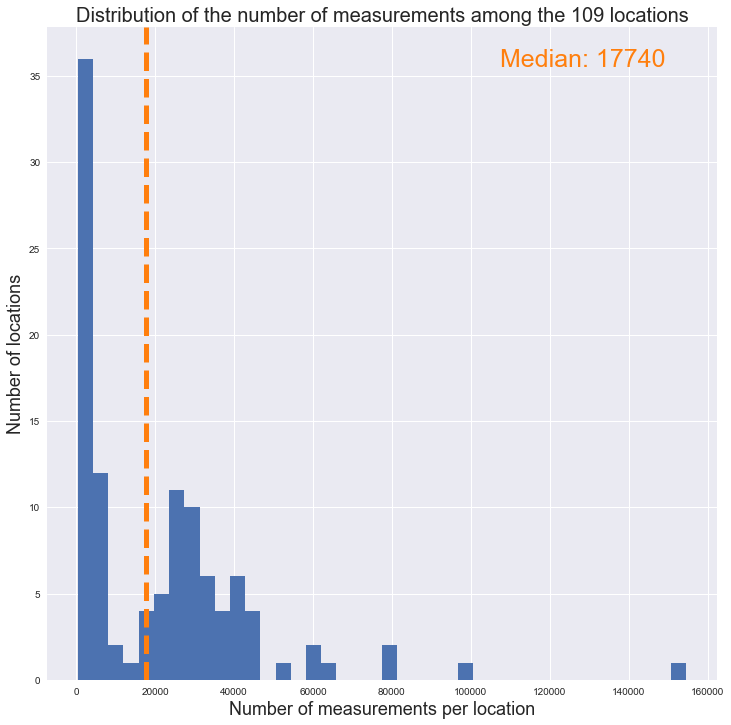

In [17]:
fig,ax = plt.subplots(figsize=(12,12))

dataDF.groupby('LOC').size().plot.hist(bins=40)

ax.set_xlabel('Number of measurements per location', fontsize=18)
ax.set_ylabel('Number of locations', fontsize=18)
ax.set_title('Distribution of the number of measurements among the {} locations'.format(dataDF['LOC'].nunique()), fontsize=20)

med = dataDF.groupby('LOC').size().median()
ax.axvline(x=med, color=orange, linewidth=5, linestyle='dashed')
ax.text(0.8,0.95, 'Median: {0:d}'.format(int(med)), horizontalalignment='center',
        verticalalignment='center', transform=ax.transAxes, fontdict={'size':25, 'color':orange})

In [18]:
inProj = Proj(init='epsg:28992')
outProj = Proj(init='epsg:4326')

In [19]:
mapa = folium.Map([52., 6.],
                  zoom_start=7,
                  tiles='cartodbpositron')

measCounts = folium.FeatureGroup(name='Measurement counts')
measKinds = folium.FeatureGroup(name='Parameters')

for loc,group in dataDF.groupby('LOCOMS'):
    if group['X_RD'].nunique() != 1:
        continue
    x = group['X_RD'].unique()[0]
    y = group['Y_RD'].unique()[0]
    lon,lat = transform(inProj, outProj, x,y)
    
    myHtml = folium.Html('''<h4>Location {}</h4>
                           <ul style="list-style-type:disc">
                          <li>Total measurements: {}</li>
                          <li>Oldest: {}</li>
                          <li>Newest: {}</li>
                            </ul>
                            '''.format(loc,len(group), group['datetime'].min().strftime('%d %b %Y'), 
                                       group['datetime'].max().strftime('%d %b %Y')), script=True)
    
    popup = folium.Popup(myHtml, max_width=2650)

    folium.Circle([lat,lon], radius=0.2*len(group), fill=True, fill_color=blue, fill_opacity=0.6, 
                  color=blue, line_opacity=0.8, popup=popup).add_to(measCounts)

    valCnts = group['PAROMS'].value_counts()
    valCnts = valCnts[valCnts > 0]
    
    maxPars = ', '.join(list(valCnts[valCnts == valCnts.max()].index))
    minPars = ', '.join(list(valCnts[valCnts == valCnts.min()].index))
    #myHtml = folium.Html('''<h4>Location {0}</h4>
    #                       <ul style="list-style-type:disc">
    #                      <li>Measured parameters {1}</li>
    #                      <li>Most measurements {2} ({3})</li>
    #                      <li>Fewest measurements {4} ({5})</li>
    #                        </ul>
    #                        '''.format(loc, group['PAR'].nunique(), valCnts.max(), maxPars,
    #                                   valCnts.min(), minPars), script=True)
    myHtml = folium.Html('''<h4>Location {0}</h4>
                           <ul style="list-style-type:disc">
                          <li>Measured parameters: {1}</li>
                          <li>Most measurements: {2} </li>
                          <li>Fewest measurements: {3} </li>
                            </ul>
                            '''.format(loc, group['PAR'].nunique(), valCnts.max(), 
                                       valCnts.min()), script=True)
        
    popup = folium.Popup(myHtml, max_width=2650)
    
    folium.Circle([lat,lon], radius=20*group['PAR'].nunique(), color=orange, 
                  fill=True, fill_color=orange, fill_opacity=0.6, 
                  line_opacity=0.8, popup=popup).add_to(measKinds)

measCounts.add_to(mapa)    
measKinds.add_to(mapa)

folium.LayerControl().add_to(mapa)

mapa.save('water_quality.html', close_file=True)

Text(0.7,0.91,'Median per location: 91')

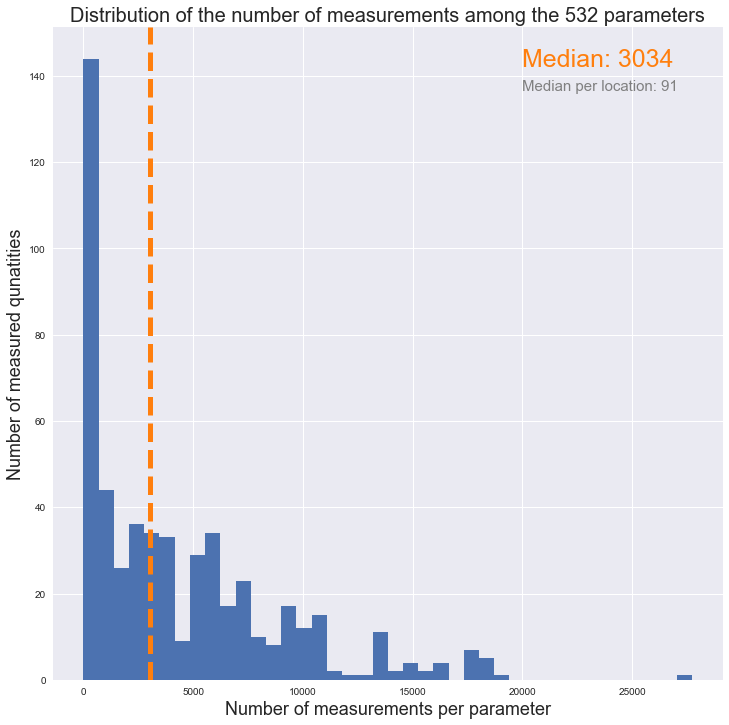

In [20]:
fig,ax = plt.subplots(figsize=(12,12))

dataDF.groupby('PAR').size().plot.hist(bins=40)

ax.set_xlabel('Number of measurements per parameter', fontsize=18)
ax.set_ylabel('Number of measured qunatities', fontsize=18)
ax.set_title('Distribution of the number of measurements among the {} parameters'.format(dataDF['PAR'].nunique()), fontsize=20)

med = dataDF.groupby('PAR').size().median()
ax.axvline(x=med, color=orange, linewidth=5, linestyle='dashed')
ax.text(0.7,0.95, 'Median: {0:d}'.format(int(med)), horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes, fontdict={'size':25, 'color':orange})

med = dataDF.groupby(['PAR','LOC']).size().median()
#ax.axvline(x=med, color=orange, linewidth=5, linestyle='dashed')
ax.text(0.7,0.91, 'Median per location: {0:d}'.format(int(med)), horizontalalignment='left', 
        verticalalignment='center', transform=ax.transAxes, fontdict={'size':15, 'color':'grey'})

Text(0.8,0.95,'Median: 234')

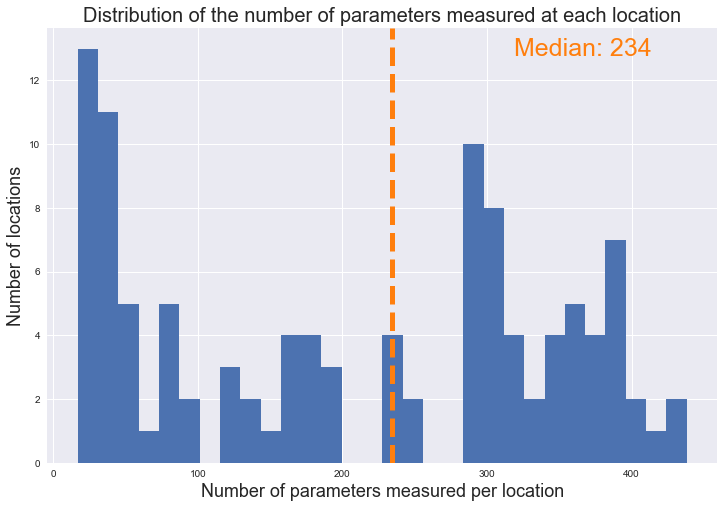

In [21]:
fig,ax = plt.subplots(figsize=(12,8))

dataDF.groupby('LOC')['PAR'].nunique().plot.hist(bins=30,ax=ax)

ax.set_xlabel('Number of parameters measured per location', fontsize=18)
ax.set_ylabel('Number of locations', fontsize=18)
ax.set_title('Distribution of the number of parameters measured at each location'.format(dataDF['PAR'].nunique()), fontsize=20)

med = dataDF.groupby('LOC')['PAR'].nunique().median()
ax.axvline(x=med, color=orange, linewidth=5, linestyle='dashed')
ax.text(0.8,0.95, 'Median: {0:d}'.format(int(med)), horizontalalignment='center', 
        verticalalignment='center', transform=ax.transAxes, fontdict={'size':25, 'color':orange})

In [22]:
mapa = folium.Map([52., 6.],
                  zoom_start=7,
                  tiles='cartodbpositron')

for loc,group in dataDF.groupby('LOCOMS'):
    if group['X_RD'].nunique() != 1:
        continue
    x = group['X_RD'].unique()[0]
    y = group['Y_RD'].unique()[0]
    lon,lat = transform(inProj, outProj, x,y)
    
    myHtml = folium.Html('''<h4>Location {0}</h4>
                           <ul style="list-style-type:disc">
                          <li>Measured parameters: {1}</li>
                          <li>Most measurements: {2} ({3})</li>
                          <li>Fewest measurements: {4} ({5})</li>
                            </ul>
                            '''.format(loc, group['PAR'].nunique(), valCnts.max(), maxPars,
                                       valCnts.min(), minPars), script=True)
       
    popup = folium.Popup(myHtml, max_width=2650)
    
    folium.Circle([lat,lon], radius=20*group['PAR'].nunique(), color=orange, 
                  fill=True, fill_color=orange, fill_opacity=0.6, 
                  line_opacity=0.8, popup=popup).add_to(mapa)

mapa.save('basic_map_measured_parameters.html')

# Taking out nutrients

In [23]:
nutrients = ["chlorofyl-a","nitraat","nitriet", 
                    "stikstof","orthofosfaat","ammonium",
                    "totaal fosfaat", "Zwevende stof", 
                    "Temperatuur", "zuurstof", "Doorzicht",
                    "Zuurgraad","Kjeldahl stikstof"]

chlorDF = dataDF[['datetime', 'LOCOMS', 'WAARDE', 'PAROMS']].copy()
chlorDF = chlorDF[chlorDF['PAROMS'].map(lambda x: x in nutrients)]

chlorDF.head()

#del dataDF

,datetime,LOCOMS,WAARDE,PAROMS
1,2006-01-05,Walcheren 70 km uit de kust,0.008,nitriet
2,2006-01-05,Walcheren 70 km uit de kust,0.002,ammonium
3,2006-01-05,Walcheren 70 km uit de kust,0.026,orthofosfaat
5,2006-01-05,Walcheren 70 km uit de kust,0.081,nitraat
6,2006-01-05,Walcheren 70 km uit de kust,0.036,totaal fosfaat


In [24]:
featDF = pd.pivot_table(chlorDF, index='datetime', columns=['PAROMS','LOCOMS']).groupby(pd.Grouper(freq='1W')).mean().stack()
featDF.columns = featDF.columns.droplevel()

# get rid of the outliers
featDF[featDF < featDF.quantile(0.005)] = np.nan
featDF[featDF > featDF.quantile(0.995)] = np.nan

featDF.head()

PAROMS                                Doorzicht  Kjeldahl stikstof  \
datetime   LOCOMS                                                    
2006-01-08 Bovensluis                       7.0               0.64   
           Dantziggat                       NaN                NaN   
           Eemmeerdijk, kilometer 23        8.0               1.60   
           Eijsden ponton                   8.0            5500.46   
           Goeree 6 km uit de kust          NaN                NaN   

PAROMS                                Temperatuur  Zuurgraad  Zwevende stof  \
datetime   LOCOMS                                                             
2006-01-08 Bovensluis                       4.100      7.700            7.0   
           Dantziggat                       1.320      7.650          147.0   
           Eemmeerdijk, kilometer 23        1.400      8.000            8.0   
           Eijsden ponton                   6.200      8.000            6.0   
           Goeree 6 km uit de kust          5.818      7.852           17.7   

PAROMS                                ammonium  chlorofyl-a  nitraat  nitriet  \
datetime   LOCOMS                                                               
2006-01-08 Bovensluis                    0.130         2.00    3.790    0.030   
           Dantziggat                    0.227         4.94    0.228    0.031   
           Eemmeerdijk, kilometer 23     0.590         3.00    2.150    0.040   
           Eijsden ponton                0.300         2.00    4.220    0.060   
           Goeree 6 km uit de kust       0.065         1.48    0.360    0.021   

PAROMS                                orthofosfaat  stikstof  totaal fosfaat  \
datetime   LOCOMS                                                              
2006-01-08 Bovensluis                        0.100       NaN        0.300000   
           Dantziggat                        0.300  0.825333        0.294667   
           Eemmeerdijk, kilometer 23         0.085       NaN        0.170000   
           Eijsden ponton                    0.150       NaN        2.510000   
           Goeree 6 km uit de kust           0.037  0.403667        0.099333   

PAROMS                                zuurstof  
datetime   LOCOMS                               
2006-01-08 Bovensluis                    10.30  
           Dantziggat                    11.18  
           Eemmeerdijk, kilometer 23     13.30  
           Eijsden ponton                12.30  
           Goeree 6 km uit de kust        9.66

In [25]:
chDF = featDF['chlorofyl-a'].reset_index()
chDF = pd.pivot_table(chDF, index='datetime', columns='LOCOMS', values='chlorofyl-a')

chDF.head()

LOCOMS,Almelo,Amerikahaven-2,"Amsterdam (kilometer 25, IJtunnel)",Andijk,Beerkanaal midden,Belfeld boven,Bocht van Watum,Boomkensdiep,Bovensluis,Brakel (Andelse Maas),...,Westzaan (kilometer 13),Wielingen,Wiene,Wissenkerke,Wolderwijd midden (zwaartepunt Wolderwijd),Zijkanaal D-1,Zijkanaal E,Zijpe,Zoutkamperlaag zeegat,Zuid Oost Lauwers oost
datetime,,,,,,,,,,,,,,,,,,,,,
2006-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,17.0,NaN,NaN,NaN,NaN,NaN
2006-01-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.58,4.04
2006-01-22,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,2.0,0.8,NaN,NaN,NaN,0.52,NaN,NaN
2006-01-29,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-02-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


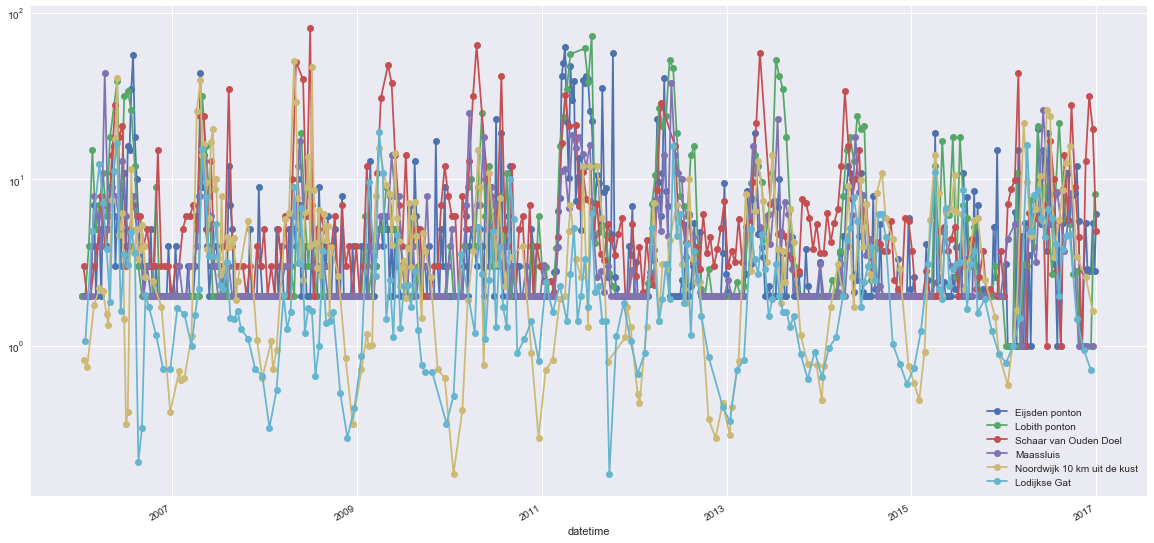

In [26]:
fig,ax = plt.subplots(figsize=(20,10))

for col in chDF.isnull().sum().sort_values()[:6].index:
    chDF[col].dropna().plot(ax=ax, label=col, marker='o')
    
ax.legend()
ax.set_yscale('log')
#ax.set_ylim(-1,200)


In [27]:
pal = sns.color_palette('hls', len(nutrients)).as_hex()

In [28]:
mapa = folium.Map([52., 6.],
                  zoom_start=7,
                  tiles='cartodbpositron')

for cnt,nut in enumerate(nutrients):
    measCounts = folium.FeatureGroup(name='{} measurements'.format(nut))
    #measKinds = folium.FeatureGroup(name='Parameters')

    for loc,group in dataDF[dataDF['PAROMS'] == nut].groupby('LOCOMS'):
        if len(group) ==0:
            continue
            
        if group['X_RD'].nunique() != 1:
            continue
        x = group['X_RD'].unique()[0]
        y = group['Y_RD'].unique()[0]
        lon,lat = transform(inProj, outProj, x,y)
        
        if group['EHD'].nunique() > 1:
            targ_unit = [u for u in group['EHD'].unique() if 'l' in u][0]
            tmpDF = group.loc[group['EHD'] == targ_unit, ['datetime','LOCOMS', 'WAARDE']].rename(columns={'datetime':'Date', 
                                                                                                                         'LOCOMS':'Location','WAARDE': nut}).copy()
        else:
            tmpDF = group[['datetime','LOCOMS', 'WAARDE']].rename(columns={'datetime':'Date', 
                                                                           'LOCOMS':'Location','WAARDE': nut}).copy()
        
        
        myChart = alt.Chart(tmpDF, title='{} at {}'.format(nut.capitalize(),loc)).mark_line(point=True).encode(
                                                                                              x='Date:T',
                                                                                              y=alt.Y('{}:Q'.format(nut), 
                                                                                                      axis=alt.Axis(title='{} ({})'.format(nut, group['EHD'].unique()[0]))),
                                                                                              #y='{}:Q'.format(nut),
                                                                                            color='Location:N').configure(color=pal[cnt])
        
        vega = folium.VegaLite(myChart, width='100%', height='100%')

        popup = folium.Popup(max_width=600).add_child(vega)

        folium.Circle([lat,lon], radius=30*len(group), fill=True, fill_color=pal[cnt], fill_opacity=0.6, 
                      color=pal[cnt], line_opacity=0.8, popup=popup).add_to(measCounts)


    measCounts.add_to(mapa)    
    #measKinds.add_to(mapa)
    
folium.LayerControl().add_to(mapa)

mapa.save('nutrient_map_timeseries.html')#'nutrients_basic_map.html', close_file=True)

In [ ]:
dataDF.loc[grp.index[2:]]

In [ ]:
import seaborn as sns

fig,ax = plt.subplots(figsize=(20,20))
sns.heatmap(featDF.corr(), annot=True, ax=ax, square=True, cmap='RdBu_r', vmax=1., vmin=-1.)

In [ ]:
incl_cols = []

cnt = 0
for ind,row in featDF.corr().iterrows():
    vals = list(row.values)
    _ = vals.pop(cnt)
    vals = np.array(vals)
    if np.any(np.abs(vals) > 0.65):
        incl_cols.append(ind)
    
    cnt += 1

incl_cols = list(set(incl_cols))
incl_cols

In [ ]:
from scipy import stats

def corrfunc(x, y, ax, **kws):
    r, _ = stats.pearsonr(x, y)
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .9), fontsize=20, xycoords=ax.transAxes)

fig,ax = plt.subplots(figsize=(4*len(featDF.columns), 4*len(featDF.columns)), nrows=len(featDF.columns), ncols=len(featDF.columns))

for i,j in product(range(len(featDF.columns)), range(len(featDF.columns))):
    if i == j:
        featDF[featDF.columns[i]].plot.hist(ax=ax[i,j], bins=15, alpha=0.6)
    elif i < j:
        ax[i,j].set_visible(False)
    else:
        featDF.plot.scatter(ax=ax[i,j], x=featDF.columns[i], y=featDF.columns[j], alpha=0.2)
        locDF = featDF[[featDF.columns[i],featDF.columns[j]]].dropna().copy()
        corrfunc(locDF[locDF.columns[0]], locDF[locDF.columns[1]], ax[i,j])
    
    sns.despine(ax=ax[i,j])
    
    if i == len(featDF.columns)-1:
        ax[i,j].set_xlabel(featDF.columns[j])
    else:
        ax[i,j].set_xlabel('')
        plt.setp(ax[i,j].get_xticklabels(), visible=False)
        
    if j == 0:
        ax[i,j].set_ylabel(featDF.columns[i])
    else:
        ax[i,j].set_ylabel('')
        plt.setp(ax[i,j].get_yticklabels(), visible=False)

plt.tight_layout()

In [ ]:
chlorDF = pd.pivot_table(data=dataDF.loc[dataDF['PAROMS'] == 'chlorofyl-a'], columns='LOCOMS', index='datetime', values='WAARDE')
chlorDF = chlorDF.resample('1m').mean()

print(chlorDF.shape)
chlorDF.head()

In [ ]:
fig,ax = plt.subplots(figsize=(25,10))

#sns.heatmap(chlorDF.T.notnull(), cmap='Blues')

tmpDF = chlorDF.copy()
tmpDF.index = tmpDF.index.map(lambda x: x.strftime('%d%b%Y'))

sns.heatmap(tmpDF.T.notnull(), xticklabels=4, yticklabels=False, cbar=False) #, cmap=['#1f77b4', '#ff7f0e'])
#sns.heatmap(tmpDF.T, xticklabels=4, vmin=0, vmax=20, yticklabels=False, cbar=False)

ax.set_ylabel('Locations', fontsize=20)
ax.set_title('Cholorfyl-a measurement availability', fontsize=25)

# Location-based correlations

In the first case, we plot the correlation of a given parameter across all locations it's measured at.

In [ ]:
import seaborn as sns
import sys

# the smalest number of measurements required to make an image that have no upper or lower limit
cutoff = 0.6
meas_cutoff = dataDF[dataDF['BGC'].isnull()].groupby('PAROMS').size().quantile(cutoff)

totPar = dataDF['PAROMS'].nunique()

cnt = 0
for par, grp in dataDF.groupby('PAROMS'):
    cnt +=1 
    sys.stdout.write('\rDoing {} ({}/{})'.format(par,cnt,totPar))
    
    if cnt < 130:
        continue 
    
    if cnt > 260:
        break
        
    # filter out upper and lower limits
    group = grp[grp['BGC'].isnull()].copy()

    if group['EHD'].nunique() > 1:
        targ_unit = [u for u in group['EHD'].unique() if 'l' in u][0]
        group = group.loc[group['EHD'] == targ_unit]             

    # skip if not measured in a lot of locations
    if group['LOCOMS'].nunique() < 10:
        continue
        
    # ignore if not enough measurements
    if len(group) < meas_cutoff:
        continue
        
    # if there is a lot of nans, don't continue
    #if corrMat.isnull().sum().sum() > 0.95*corrMat.size:
    #    continue
                
    tmpDF = pd.pivot_table(data=group, index='datetime', columns='LOCOMS', values='WAARDE')
    corrMat = tmpDF.corr(min_periods=12)

    corrMat = corrMat.dropna(how='all')
    corrMat = corrMat.T.dropna(how='all').T

    mask = np.zeros_like(corrMat, dtype=np.bool)
    mask[np.triu_indices_from(mask,1)] = True

    fig,ax = plt.subplots(figsize=(3*corrMat.shape[0], corrMat.shape[1]), 
                          ncols=3)

    sns.heatmap(corrMat, ax=ax[0], mask=mask, annot=True, vmin=-1, vmax=1, cmap='RdBu', 
                square=True, fmt='.2f', annot_kws={'fontsize':16}, cbar=False)
    ax[0].set_title('Parameter: {} ({} measurements, daily)'.format(par, len(group)), fontsize=25)
    ax[0].set_xticklabels(ax[0].get_xmajorticklabels(), fontdict={'fontsize': 22})
    ax[0].set_yticklabels(ax[0].get_ymajorticklabels(), fontdict={'fontsize': 22})
    
    tmpDF = pd.pivot_table(data=group, index='datetime', columns='LOCOMS', values='WAARDE').groupby(pd.Grouper(freq='1W')).mean()
    corrMat = tmpDF.corr(min_periods=12)
    
    corrMat = corrMat.dropna(how='all')
    corrMat = corrMat.T.dropna(how='all').T

    mask = np.zeros_like(corrMat, dtype=np.bool)
    mask[np.triu_indices_from(mask,1)] = True

    sns.heatmap(corrMat, ax=ax[1], mask=mask, annot=True, vmin=-1, vmax=1, cmap='RdBu', 
                square=True, fmt='.2f', annot_kws={'fontsize':16}, cbar=False)
    ax[1].set_title('Parameter: {} ({} measurements, weekly)'.format(par, len(group)), fontsize=25)
    ax[1].set_xticklabels(ax[1].get_xmajorticklabels(), fontdict={'fontsize': 22})
    ax[1].set_yticklabels(ax[1].get_ymajorticklabels(), fontdict={'fontsize': 22})

    tmpDF = pd.pivot_table(data=group, index='datetime', columns='LOCOMS', values='WAARDE').groupby(pd.Grouper(freq='1m')).mean()
    corrMat = tmpDF.corr(min_periods=12)
    
    corrMat = corrMat.dropna(how='all')
    corrMat = corrMat.T.dropna(how='all').T

    mask = np.zeros_like(corrMat, dtype=np.bool)
    mask[np.triu_indices_from(mask,1)] = True

    sns.heatmap(corrMat, ax=ax[2], mask=mask, annot=True, vmin=-1, vmax=1, cmap='RdBu', 
                square=True, fmt='.2f', annot_kws={'fontsize':16}, cbar=False)
    ax[2].set_title('Parameter: {} ({} measurements, montly)'.format(par, len(group)), fontsize=25)
    ax[2].set_xticklabels(ax[2].get_xmajorticklabels(), fontdict={'fontsize': 22})
    ax[2].set_yticklabels(ax[2].get_ymajorticklabels(), fontdict={'fontsize': 22})

    fig.savefig('loc_corrs/location_corr_{}.svg'.format(par), bbox_inches='tight', pad_inches=0.2, format='svg')
    
    fig.clf()
    plt.close(fig)
    
    gc.collect()
    
    #if cnt > 35:
    #    break

    #break

In [ ]:
import sys
import seaborn as sns

# the smalest number of measurements required to make an image that have no upper or lower limit
cutoff = 0.6
meas_cutoff = dataDF[dataDF['BGC'].isnull()].groupby('PAROMS').size().quantile(cutoff)

totLocs = dataDF['LOCOMS'].nunique()

cnt = 0
for par, grp in dataDF.groupby('LOCOMS'):
    cnt +=1 
    sys.stdout.write('\rDoing {} ({}/{})'.format(par,cnt,totLocs))
            
    # filter out upper and lower limits
    group = grp[grp['BGC'].isnull()].copy()
                        
    
    tmpDF = pd.pivot_table(data=group, index='datetime', columns='PAROMS', values='WAARDE')
    corrMat = tmpDF.corr(min_periods=12)

    corrMat = corrMat.dropna(how='all')
    corrMat = corrMat.T.dropna(how='all').T

    np.fill_diagonal(corrMat.values, np.nan)

    corrMat = corrMat[corrMat.abs() > 0.9].dropna(how='all').T
    corrMat = corrMat[corrMat.abs() > 0.9].dropna(how='all').T

    np.fill_diagonal(corrMat.values, 1.)

    mask = np.zeros_like(corrMat, dtype=np.bool)
    mask[np.triu_indices_from(mask,1)] = True
    
    if corrMat.shape[0] == 0:
        continue
        
    #fig,ax = plt.subplots(figsize=(int(1.5*corrMat.shape[0]), int(0.5*corrMat.shape[1])), 
    #                      ncols=3)
    fig,ax = plt.subplots(figsize=(corrMat.shape[0], 0.5*corrMat.shape[1]))

    sns.heatmap(corrMat, ax=ax, mask=mask, annot=True, vmin=-1, vmax=1, cmap='RdBu', 
                square=True, fmt='.2f', annot_kws={'fontsize':13}, cbar=False)
    ax.set_title('Location: {} ({} measurements, daily)'.format(par, len(group)), fontsize=25)
    ax.set_xticklabels(ax.get_xmajorticklabels(), fontdict={'fontsize': 22})
    ax.set_yticklabels(ax.get_ymajorticklabels(), fontdict={'fontsize': 22})
    
    '''
    tmpDF = pd.pivot_table(data=group, index='datetime', columns='PAROMS', values='WAARDE').groupby(pd.Grouper(freq='1W')).mean()
    corrMat = tmpDF.corr(min_periods=12)
    
    np.fill_diagonal(corrMat.values, np.nan)

    corrMat = corrMat[corrMat.abs() > 0.9].dropna(how='all').T
    corrMat = corrMat[corrMat.abs() > 0.9].dropna(how='all').T

    np.fill_diagonal(corrMat.values, 1.)

    mask = np.zeros_like(corrMat, dtype=np.bool)
    mask[np.triu_indices_from(mask,1)] = True

    sns.heatmap(corrMat, ax=ax[1], mask=mask, annot=True, vmin=-1, vmax=1, cmap='RdBu', 
                square=True, fmt='.2f', annot_kws={'fontsize':16}, cbar=False)
    ax[1].set_title('Location: {} ({} measurements, weekly)'.format(par, len(group)), fontsize=25)
    ax[1].set_xticklabels(ax[1].get_xmajorticklabels(), fontdict={'fontsize': 22})
    ax[1].set_yticklabels(ax[1].get_ymajorticklabels(), fontdict={'fontsize': 22})

    tmpDF = pd.pivot_table(data=group, index='datetime', columns='PAROMS', values='WAARDE').groupby(pd.Grouper(freq='1m')).mean()
    corrMat = tmpDF.corr(min_periods=12)
    
    np.fill_diagonal(corrMat.values, np.nan)

    corrMat = corrMat[corrMat.abs() > 0.9].dropna(how='all').T
    corrMat = corrMat[corrMat.abs() > 0.9].dropna(how='all').T

    np.fill_diagonal(corrMat.values, 1.)

    mask = np.zeros_like(corrMat, dtype=np.bool)
    mask[np.triu_indices_from(mask,1)] = True

    sns.heatmap(corrMat, ax=ax[2], mask=mask, annot=True, vmin=-1, vmax=1, cmap='RdBu', 
                square=True, fmt='.2f', annot_kws={'fontsize':16}, cbar=False)
    ax[2].set_title('Location: {} ({} measurements, monthly)'.format(par, len(group)), fontsize=25)
    ax[2].set_xticklabels(ax[2].get_xmajorticklabels(), fontdict={'fontsize': 22})
    ax[2].set_yticklabels(ax[2].get_ymajorticklabels(), fontdict={'fontsize': 22})
    '''
    
    fig.savefig('par_corrs/parameter_corr_{}.svg'.format(par), bbox_inches='tight', pad_inches=0.2, format='svg')
    
    fig.clf()
    plt.close(fig)
    
    gc.collect()
    
    #break

In [ ]:
fig,ax = plt.subplots(figsize=(24,6), ncols=4)

#corrs = [-0.9, -0.3, 0., 0.5, 0.95]
corrs = [0., 0.5, 0.9, 0.95]

for i in range(4):
    m = [0., 0.]
    s = [1., 1.]

    corr = corrs[i]        # correlation
    covs = [[s[0]**2          , s[0]*s[1]*corr], 
            [s[0]*s[1]*corr,           s[1]**2]] 

    fake = np.random.multivariate_normal(m,covs, 1000).T

    #fig,ax = plt.subplots(figsize=(10,10))

    ax[i].scatter(fake[0],fake[1], alpha=0.6)
    #ax[i].set_title('{0:.2f}'.format(corr), fontsize=40)
    
    ax[i].get_xaxis().set_visible(False)
    ax[i].get_yaxis().set_visible(False)

    ax[i].text(0.5,0.9, '{0:.2f}'.format(corr), horizontalalignment='center',
            verticalalignment='center', transform=ax[i].transAxes, fontdict={'size':30},
            bbox=dict(facecolor='white', alpha=0.9, edgecolor='black', boxstyle='round'))
    
plt.tight_layout()

fig.savefig('correlation_examples.png', bbox_inches='tight', pad_inches=0.2, 
            dpi=300, transparent=True)

In [ ]:
corrLim = 0.9
totLocs = dataDF['LOCOMS'].nunique()

corrDF = pd.DataFrame(columns=['parameters', 'uncorrelated'])

cnt = 0
for par, grp in dataDF.groupby('LOCOMS'):
    cnt +=1 
    sys.stdout.write('\rDoing {} ({}/{})'.format(par,cnt,totLocs))
    
    tmp_dict = {'parameters': grp['PAROMS'].nunique()}
    
    # filter out upper and lower limits
    group = grp[grp['BGC'].isnull()].copy()
    
    if group['EHD'].nunique() > 1:
        targ_unit = [u for u in group['EHD'].unique() if 'l' in u][0]
        group = group.loc[group['EHD'] == targ_unit]             
    
    tmpDF = pd.pivot_table(data=group, index='datetime', columns='PAROMS', values='WAARDE')
    corrMat = tmpDF.corr(min_periods=12)

    corrMat = corrMat.dropna(how='all')
    corrMat = corrMat.T.dropna(how='all').T

    np.fill_diagonal(corrMat.values, np.nan)

    corrMat = corrMat[corrMat.abs() > corrLim].dropna(how='all').T
    corrMat = corrMat[corrMat.abs() > corrLim].dropna(how='all').T

    np.fill_diagonal(corrMat.values, 1.)

    mask = np.zeros_like(corrMat, dtype=np.bool)
    mask[np.triu_indices_from(mask,1)] = True
    
    if corrMat.shape[0] == 0:
        continue
    
    g = nx.Graph()
    
    for r in corrMat.index:
        if r not in g.nodes:
            g.add_node(r)
            
        for c in corrMat.columns:
            if r == c:
                continue
            
            if c not in g.nodes:
                g.add_node(c)
            
            if np.abs(corrMat.loc[r,c]) >= corrLim:
                g.add_edge(r,c)
    
    tmp_dict['uncorrelated'] = tmp_dict['parameters'] - corrMat.shape[0] + nx.number_connected_components(g)
    corrDF.loc[par] = tmp_dict

In [ ]:
corrDF.head()

In [ ]:
corrDF.loc['Terschelling 4 km uit de kust']

In [ ]:
(corrDF['parameters'] - corrDF['uncorrelated']).mean()


In [ ]:
upperDF = pd.DataFrame(index=dataDF['PAROMS'].unique(), columns=['measurements', 'unique', 'upperFrac'])

cnt = 0
for par, grp in dataDF.groupby('PAROMS'):
    cnt +=1 
    sys.stdout.write('\rDoing {} ({}/{})'.format(par,cnt,dataDF['PAROMS'].nunique()))
    
    tmpDF = grp.copy()
    tmpDF['val'] = tmpDF.apply(lambda x: '<{}'.format(x['WAARDE']) if x['BGC'] == '<' else str(x['WAARDE']), axis=1)
    
    tmpDict = {'unique': tmpDF['val'].nunique(), 'upperFrac':tmpDF['val'].map(lambda x: '<' in x).sum()/len(tmpDF), 
               'measurements':len(grp)}
    
    upperDF.loc[par] = tmpDict

In [ ]:
upperDF.sample(5)

In [ ]:
sns.pairplot(upperDF, size=5, diag_kind='hist')

# Spatial clustering from temporal correlations

Our data contains 115 locations, where a combined 532 parameters are being measured. Let's look at basic similarity - for each parameter, we create a complete correlation matrix (daily, weekly, monthly). Then we average the pariwise correlations and cluster the results. finally, we draw the data on the map to see whether we get some kind of a spatial corelation.

In [ ]:
dataDF = dataDF[dataDF['X_RD'].notnull()].copy()

In [ ]:
locations = dataDF['LOCOMS'].unique()

corrMats = {'day':np.zeros((len(locations), len(locations))),
            'week':np.zeros((len(locations), len(locations))),
            'month':np.zeros((len(locations), len(locations)))}

no_corrs = {'day':np.zeros((len(locations), len(locations))),
            'week':np.zeros((len(locations), len(locations))),
            'month':np.zeros((len(locations), len(locations)))}

freq_dict = {'day': '1D', 'week': '1W', 'month':'1m'}

cnt = 0
for par, group in dataDF.groupby('PAROMS'):
    cnt += 1
    sys.stdout.write('\rDoing {} ({}/{})'.format(par,cnt,dataDF['PAROMS'].nunique()))
    
    if group['EHD'].nunique() > 1:
        targ_unit = list(group['EHD'].value_counts().index)[0]
        grp = group[group['EHD'] == targ_unit].copy()
    else:
        grp = group.copy()
        
    for period in ['day', 'week', 'month']:
        tmpDF = pd.pivot_table(grp, index='datetime', columns=['LOCOMS'], values='WAARDE').groupby(pd.Grouper(freq=freq_dict[period])).mean()
        tmpDF = tmpDF.corr(min_periods=12) # with roughly one measurement a month, they should have at least a year of overlaps
        tmpDF = tmpDF.reindex(index=locations, columns=locations)

        no_corrs[period] = no_corrs[period] + tmpDF.notnull().applymap(int)

        tmpDF.fillna(0, inplace=True)
        tmpDF = tmpDF.abs()
        
        corrMats[period] = corrMats[period] + tmpDF.values
    
for period in corrMats:
    corrMats[period] = corrMats[period]/no_corrs[period]

**TODO:** use weighted averages to get the mean correlation (weighted by the number of overlapping points)

In [ ]:
locations = dataDF['LOCOMS'].unique()
parameters = dataDF['PAROMS'].unique()

corrMats = {'day':np.zeros((len(locations), len(locations), len(parameters))),
            'week':np.zeros((len(locations), len(locations), len(parameters))),
            'month':np.zeros((len(locations), len(locations), len(parameters)))}

corrWeigths = {'day':np.zeros((len(locations), len(locations), len(parameters))),
               'week':np.zeros((len(locations), len(locations), len(parameters))),
               'month':np.zeros((len(locations), len(locations), len(parameters)))}

freq_dict = {'day': '1D', 'week': '1W', 'month':'1m'}

cnt = 0
for par, grp in dataDF.groupby('PAROMS'):
    cnt += 1
    sys.stdout.write('\rDoing {} ({}/{})'.format(par,cnt,dataDF['PAROMS'].nunique()))
    
    for period in ['day', 'week', 'month']:
        hlpDF = pd.pivot_table(grp, index='datetime', columns=['LOCOMS'], values='WAARDE').groupby(pd.Grouper(freq=freq_dict[period])).mean()
        tmpDF = hlpDF.corr(min_periods=12) # with roughly one measurement a month, they should have at least a year of overlaps
        tmpDF = tmpDF.reindex(index=locations, columns=locations)

        #no_corrs[period] = no_corrs[period] + tmpDF.notnull().applymap(int)

        tmpDF.fillna(0, inplace=True)
        tmpDF = tmpDF.abs()
        
        corrMats[period][:,:,cnt-1] = tmpDF.values
        
        # calcualte weights - more values used to calculate the correlation means more confidence
        for c in range(12,len(grp),12):
            tmpDF = hlpDF.corr(min_periods=c)
            tmpDF = tmpDF.reindex(index=locations, columns=locations)
            
            if np.all(tmpDF.isnull()):
                break
                
            corrWeights[period][:,:,cnt-1] = corrWeights[period][:,:,cnt-1] + tmpDF.notnull().applymap(int)
            
    
#for period in corrMats:
#    corrMats[period] = np.ma.array(corrMats[period], mask=np.isfinite(corrMats[period]))
#    corrMats[period] = np.ma.average(corrMats[period], weights=corrWeights[period], axis=2)

In [ ]:
from sklearn.cluster import AffinityPropagation

In [ ]:
ap = AffinityPropagation(affinity='precomputed')

for period in ['day', 'week', 'month']:
    print(ap.fit_predict(corrMats[period].fillna(0)))

In [ ]:
ap = AffinityPropagation(affinity='precomputed')

overlap_dict = {}

for period in ['day', 'week', 'month']:
    clusters = ap.fit_predict(corrMats[period].fillna(0))
    
    cl_dict = defaultdict(list)
    for i,location in zip(clusters, corrMats[period].columns):
        cl_dict[i].append(dataDF.loc[dataDF['LOCOMS'] == location,'SGB'].values[0])
    
    for key in cl_dict:
        cl_dict[key] = list(set(cl_dict[key]))
    
    matrixDF = pd.DataFrame(index=range(max(clusters)+1), 
                            columns=range(max(clusters)+1))
    
    for i in matrixDF.index:
        for j in matrixDF.columns:
            matrixDF.loc[i,j] = len(set(cl_dict[i]).intersection(set(cl_dict[j])))
    
    overlap_dict[period] = matrixDF

In [ ]:
for period in ['day','week', 'month']:
    fig,ax = plt.subplots(figsize=(15,15))

    mask = np.zeros_like(overlap_dict[period], dtype=np.bool)
    mask[np.triu_indices_from(mask,1)] = True

    sns.heatmap(overlap_dict[period], ax=ax, square=True, annot=True, annot_kws={'size':15}, cmap='inferno_r', mask=mask, cbar=False)

    ax.set_xlabel('Cluster label', fontsize=18)
    ax.set_ylabel('Cluster label', fontsize=18)
    ax.set_title('Stroomgebied overlaps ({} matching)'.format(period), fontsize=22)


In [ ]:
inProj = Proj(init='epsg:28992')
outProj = Proj(init='epsg:4326')

#folium.PolyLine(locations=[p1, p2], color='blue').add_to(some_map)

mapa = folium.Map([52., 6.],
                  zoom_start=7,
                  tiles='cartodbpositron')

features = {'day': folium.FeatureGroup(name='daily aggregation'),
            'daylines': folium.FeatureGroup(name='daily aggregation (lines)'),
            'week': folium.FeatureGroup(name='weekly aggregation'),
            'weeklines': folium.FeatureGroup(name='weekly aggregation (lines)'),
            'month': folium.FeatureGroup(name='monthly aggregation'),
            'monthlines': folium.FeatureGroup(name='monthly aggregation (lines)'),}

for period in ['day','week','month']:
    ap = AffinityPropagation(affinity='precomputed')
    cl = ap.fit_predict(corrMats[period].fillna(0))
    
    centers = ap.cluster_centers_indices_
    
    loc_dict = dict(zip(locations,cl))
    
    pal = sns.color_palette('hls', len(set(cl))).as_hex()
    
    for loc,group in dataDF.groupby('LOCOMS'):
        if group['X_RD'].nunique() != 1:
            continue
        x = group['X_RD'].unique()[0]
        y = group['Y_RD'].unique()[0]
        lon,lat = transform(inProj, outProj, x,y)

        myHtml = folium.Html('''<h4>Location {}</h4>
                               <ul style="list-style-type:disc">
                              <li>Cluster: {}</li>
                                </ul>
                                '''.format(loc, loc_dict[loc]), script=True)

        popup = folium.Popup(myHtml, max_width=2650)

        folium.Circle([lat,lon], radius=1000, fill=True, fill_color=pal[loc_dict[loc]], fill_opacity=0.7, 
                      color=pal[loc_dict[loc]], line_opacity=0.8, popup=popup).add_to(features[period])
        
        # draw lines to the cluster centers
        if list(locations).index(loc) in centers:
            continue
        else:
            cl_center = locations[centers[loc_dict[loc]]]
            cx = dataDF.loc[dataDF['LOCOMS'] == cl_center, 'X_RD'].values[0]
            cy = dataDF.loc[dataDF['LOCOMS'] == cl_center, 'Y_RD'].values[0]
            clon,clat = transform(inProj, outProj, cx,cy)
            
            p1 = [lat,lon]
            p2 = [clat,clon]
            folium.PolyLine([p1,p2], color=pal[loc_dict[loc]]).add_to(features['{}lines'.format(period)])

    features[period].add_to(mapa)    
    features['{}lines'.format(period)].add_to(mapa)    

folium.LayerControl().add_to(mapa)

mapa.save('clustered_locations.html', close_file=True)

**TODO:** find a way to properly weight the correlation (for example by using the number of measurements used)

In [ ]:
locations = dataDF['LOCOMS'].unique()
parameters = dataDF['PAROMS'].unique()

corrMats = {'day':np.zeros((len(locations), len(locations), len(parameters))),
            'week':np.zeros((len(locations), len(locations), len(parameters))),
            'month':np.zeros((len(locations), len(locations), len(parameters)))}

corrWeights = {'day':np.zeros((len(locations), len(locations), len(parameters))),
            'week':np.zeros((len(locations), len(locations), len(parameters))),
            'month':np.zeros((len(locations), len(locations), len(parameters)))}


#no_corrs = {'day':np.zeros((len(locations), len(locations))),
#            'week':np.zeros((len(locations), len(locations))),
#            'month':np.zeros((len(locations), len(locations)))}

freq_dict = {'day': '1D', 'week': '1W', 'month':'1m'}

for cnt, par in enumerate(parameters):
    sys.stdout.write('\rDoing {} ({}/{})'.format(par,cnt+1,len(parameters)))
    
    for period in ['day', 'week', 'month']:
        tmpDF = pd.pivot_table(dataDF[dataDF['PAROMS'] == par], 
                               index='datetime', columns=['LOCOMS'], 
                               values='WAARDE').groupby(pd.Grouper(freq=freq_dict[period])).mean()
        
        for i,j in product(enumerate(locations),enumerate(locations)):
            if (i[1] not in tmpDF.columns) or (j[1] not in tmpDF.columns):
                corrWeights[period][i[0],j[0]] = 0.
            else:
                corrWeights[period][i[0],j[0]] = len(tmpDF.dropna(subset=[i[1], j[1]])) # np.sum(np.all(tmpDF[[i[1],j[1]]].values,axis=1))
        
        tmpDF = tmpDF.corr(min_periods=12) # with roughly one measurement a month, they should have at least a year of overlaps
        tmpDF = tmpDF.reindex(index=locations, columns=locations)

        #no_corrs[period] = no_corrs[period] + tmpDF.notnull().applymap(int)

        tmpDF.fillna(0, inplace=True)
        tmpDF = tmpDF.abs()
        
        corrMats[period][:,:,cnt] = tmpDF.values
    
for period in corrMats:
    corrMats[period] = np.average(corrMats[period], axis=2, weights=corrWeights[period])

In [ ]:
chlorDF = pd.pivot_table(data=dataDF[dataDF['PAROMS'] == 'chlorofyl-a'], columns='LOCOMS', index='datetime', values='WAARDE')

chlorDF.head()

In [ ]:
fig,ax = plt.subplots(figsize=(15,15), nrows=3)

sns.heatmap(chlorDF.loc['2016', chlorDF.columns[6:12]].resample('1D').mean().T.notnull(), 
            ax=ax[0], xticklabels=False, cbar=False)

ax[0].set_ylabel('')
ax[0].set_xlabel('')

sns.heatmap(chlorDF.loc['2016', chlorDF.columns[6:12]].resample('1W').mean().T.notnull(), 
            ax=ax[1], xticklabels=False, cbar=False)

ax[1].set_ylabel('')
ax[1].set_xlabel('')

sns.heatmap(chlorDF.loc['2016', chlorDF.columns[6:12]].resample('1M').mean().T.notnull(), 
            ax=ax[2], xticklabels=False, cbar=False)

ax[2].set_ylabel('')
ax[2].set_xlabel('2016', fontsize=20)

plt.tight_layout()

# Modelling the chlorophyl value

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split

In [ ]:
to_drop = []

for i,col in enumerate(featDF.isnull().sum().sort_values(ascending=False).index):
    if col == 'chlorofyl-a':
        continue
    to_drop.append(col)
    print('With {} worst columns dropped we get {} samples.'.format(i+1, len(featDF.drop(to_drop, axis=1).dropna())))

Let's drop three worst columns:

In [ ]:
to_drop = list(featDF.isnull().sum().sort_values(ascending=False).index[:3])
featDF.drop(to_drop, axis=1, inplace=True)

print(featDF.shape)
featDF.dropna(inplace=True)
print(featDF.shape)

In [ ]:
X = featDF.drop('chlorofyl-a', axis=1).values
y = featDF['chlorofyl-a'].values

trainX, testX, trainY, testY = train_test_split(X,y, test_size=0.2)

In [ ]:
et = ExtraTreesRegressor(n_estimators=150)
et.fit(trainX,trainY)

In [ ]:
from sklearn.metrics import mean_squared_error as mse

pred = et.predict(testX)

def get_relative_error(true,pred):
    return 1 - np.sqrt(np.mean(((true-pred)/true)**2))

print('The mean accuracy is {0:.2f}%'.format(get_relative_error(testY, pred)))

# Geospatial data

In [ ]:
import geopandas as gpd

In [ ]:
myGDF = gpd.read_file('/media/ondrej/500/ds_data/rws_datalab/Waterlichamen/stroomgebied_districten_v.shp')

print(myGDF.crs)
print(myGDF.shape)

myGDF.head()

In [ ]:
fig, ax = plt.subplots(figsize=(10,15))

myGDF.plot(ax=ax, linewidth=3, edgecolor='black', cmap='Set1')
#for poly in myGDF['geometry']:
#    gpd.plotting.plot_dataframe(ax, poly, linewidth=2, edgecolor='grey')
#
#gpd.plotting.plot_dataframe(myGDF,ax=ax, style_kwds={'linewidth':3})

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.tick_params(size=0) #visible=False)

# Modelling locations based on the big locations - HIGHLY UNFINISHED

In [ ]:
dataDF['LOCOMS'].value_counts()[:3]

In [ ]:
dataDF.head()

In [ ]:
#eijsDF = pd.DataFrame(index=pd.date_range(start=dataDF.loc[dataDF['LOCOMS'] == 'Eijsden ponton','datetime'].min(), 
#                                          end=dataDF.loc[dataDF['LOCOMS'] == 'Eijsden ponton','datetime'].max()))

eijsDF = None

cnt = 0

tot_pars = dataDF.loc[(dataDF['LOCOMS'] == 'Eijsden ponton') & 
                      (dataDF['BGC'].isnull()), 'PAROMS'].nunique()

for par,grp in dataDF[(dataDF['LOCOMS'] == 'Eijsden ponton') & 
                      (dataDF['BGC'].isnull())].groupby('PAROMS'):
    
    if len(grp) == 0:
        continue
    
    cnt += 1
    
    sys.stdout.write('\rDoing {} ({}/{})'.format(par,cnt,tot_pars))
    
    if grp['EHD'].nunique() == 1 and grp['HDH'].nunique() == 1:
        tmpDF = pd.DataFrame(grp.set_index('datetime')['WAARDE'])
        tmpDF.columns = [par]
    else:
        targ_unit = list(grp['EHD'].value_counts().index)[0]
        tmpDF = grp[grp['EHD'] == targ_unit]
        if tmpDF['HDH'].nunique() == 1:
            tmpDF = tmpDF[['WAARDE','datetime']].set_index('datetime').rename(columns={'WAARDE': par})
        else:
            tmpDF = pd.pivot_table(tmpDF, columns='HDH', index='datetime', values='WAARDE')
            tmpDF.rename(columns=dict(zip(tmpDF.columns,['{}_{}'.format(par,hdh) for hdh in tmpDF.columns])), inplace=True)
            
    if eijsDF is not None:
        eijsDF = pd.merge(eijsDF,tmpDF, left_index=True, right_index=True, how='outer')
    else:
        eijsDF = tmpDF.copy()

eijsDF.head()

#pd.pivot_table(dataDF[(dataDF['LOCOMS'] == 'Eijsden ponton') & 
#                               (dataDF['BGC'].isnull())], columns='PAROMS', index='datetime', values='WAARDE')

In [ ]:
filteredDF = dataDF[(dataDF['LOCOMS'] == 'Eijsden ponton') & 
                               (dataDF['BGC'].isnull())]

In [ ]:
15*21

In [ ]:
pd.pivot_table(dataDF[(dataDF['LOCOMS'] == 'Eijsden ponton') & 
                               (dataDF['BGC'].isnull())], columns=['PAROMS','EHD'], index='datetime', values='WAARDE')